## Processing the data

In [36]:
count_array = []

#Plotting the histogram of count for each entry (i.e. for each user,song pair avaulable in the dataset)
with open('kaggle_visible_evaluation_triplets.txt','r') as f:
    for line in f:
        user, song, count = line.split()
        count = int(count)
        count_array.append(count)

Text(0.5, 1.0, 'Count Histogram')

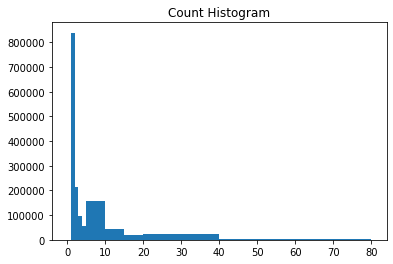

In [37]:
#Plotting the histogram to get an idea about the distribution of the count values

from matplotlib import pyplot as plt 
import numpy as np  

plt.hist(count_array,bins=[0,1,2,3,4,5,10,15,20,40,60,80]) 
  
plt.title("Count Histogram") 

In [4]:
#From above histogram we have created different class of count values.
#Because we have implecit data
#We don't have user rattings for song. So, we focused on the user behaviour.
#We can have a higher confidence on the song if user has listened to it more than once.


#userToSongCount is a dictionary 
#Where key is the user and value is an array of pairs of song and count
userToSongCount = dict()

#songToUserCount is a dictionary
#Where key is the song and value is an array of pairs of user and count
songToUserCount = dict()

total_Entries = 0

with open('kaggle_visible_evaluation_triplets.txt','r') as f:
    for line in f:
        user, song, count = line.split()
        total_Entries += 1
        count = int(count)
        if(count>=3):
            if(count<=5):
                count = 3
            elif(count<=10):
                count = 4
            elif(count<=40):
                count = 5
            else:
                count = 6
                
        if user in userToSongCount:
            userToSongCount[user].append((song,count))
        else:
            userToSongCount[user] = [(song,count)]

        if song in songToUserCount:
            songToUserCount[song].append((user,count))
        else:
            songToUserCount[song] = [(user,count)]

#songs is a list of all different songs in the dataset
songs = sorted(songToUserCount.keys())
#users is a list of all different users in the dataset
users = sorted(userToSongCount.keys())

#songsToIndex maps each song to its index in the songs list
songsToIndex = dict()

#usersToIndex maps each user to its index in the users list
usersToIndex = dict()

for n, song in enumerate(songs, start=0):
    songsToIndex[song] = n

for n, user in enumerate(users, start=0):
    usersToIndex[user] = n

totalSongs = len(songs)
totalUsers = len(users)

In [33]:
print("Total users:", totalUsers)
print("Total songs:", totalSongs)
print("Total entries:", total_Entries)

Total users: 110000
Total songs: 163206
Total entries: 1450933


## Splitting the data into train test set

In factorisation algorithm training dataset must have atleast one entry for every song and user
If we split randomly and supposer all entry corresponds to a perticular song went to test data, so after factorisation we don't have any information about that song. So, we can't predict anythig about it and same goes for user.

In [108]:
#From above histogram we can see that we have engough users and songs which have more than 22 entries.
# So, users and songs which have more than 22 entries, we moved 11 entries form that into test set.

songEntry = {}
userEntry = {}
train_data = dict()
test_data = dict()

for user in userToSongCount:
    userEntry[user] = len(userToSongCount[user])

for song in songToUserCount:
    songEntry[song] = len(songToUserCount[song])

for user in userToSongCount:
    #if user has less than 24 entries then move all entries into train set
    if(userEntry[user]>=22):
        mx=0
        #Now this user has more than 22 entries
        #So. we moved only entries which have enhough entries for that song also.
        #We are moving only 11 entries for that user
        for(song,count) in userToSongCount[user]:
            if(songEntry[song]>=11 and mx<11):
                mx+=1
                test_data[(user,song)] = count
                songEntry[song]-=1 
            else:
                train_data[(user,song)] = count 
    else:
        for(song,count) in userToSongCount[user]:
            train_data[(user,song)] = count

In [109]:
print("Length of train data:", len(train_data))
print("Length of test data:", len(test_data))

Length of train data: 1263759
Length of test data: 187174


In [110]:
# We are creating userToSongCount and songToUserCount for train data

train_userToSongCount = dict()
train_songToUserCount = dict()

for (user,song) in train_data:
    if user in train_userToSongCount:
        train_userToSongCount[user].append((song,train_data[(user,song)]))
    else:
        train_userToSongCount[user] = [(song,train_data[(user,song)])]

    if song in train_songToUserCount:
        train_songToUserCount[song].append((user,train_data[(user,song)]))
    else:
        train_songToUserCount[song] = [(user,train_data[(user,song)])]

In [111]:
train_songs = sorted(train_songToUserCount.keys())
train_users = sorted(train_userToSongCount.keys())

print("Total users in train data:", len(train_users))
print("Total songs in train data:", len(train_songs))

Total users in train data: 110000
Total songs in train data: 163206


In [112]:
#number of latent factors we are considering
no_features = 10

## Simple Factorisation Algorithm

In [113]:
song_averages = {}
user_offsets_averages = {}

# Calculate average song play count
# for given song average is sum of total play counts of that songs / number of users listened that song
for song in songs:
    song_averages[song] = sum(map(lambda x: x[1], train_songToUserCount[song])) / len(train_songToUserCount[song])


# Calculate average user offset
# Offset of given song and user = song play count for that user - average song play count of that song
# Average offset of a user = sum of offsets of all songs he/she plays / number of songs he/she plays
for user in users:
    user_offsets_averages[user] = sum(map(lambda x: (x[1] - song_averages[x[0]]), train_userToSongCount[user])) / len(train_userToSongCount[user])

# Function to calculate baseline prediction
def baseline_prediction(user, song):
    return song_averages[song] + user_offsets_averages[user]

In [114]:
# For user_feature Matrix
rows = no_features
cols = totalUsers

# Initializing user_feature matrix
user_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

# For song_feature Matrix
rows = no_features
cols = totalSongs

# Initializing song_feature matrix
song_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

In [115]:
LearningRate = 0.01

In [116]:
# To get prediction for a user and a song
# We are calculating the dot product of user_feature of that user and song_feature of that song

def prediction(user, song):
    predicted_count = 0
    for i in range(no_features):
        predicted_count += user_feature[i][usersToIndex[user]] * song_feature[i][songsToIndex[song]]
    return predicted_count

In [117]:
#Simple train function
def train(user, song, count, feature_index, baseline):
    err = 0
    if(baseline):
        err = count - baseline_prediction(user, song)
    else:
        err = count - prediction(user, song)
        
    uv = user_feature[feature_index][usersToIndex[user]]
    sv = song_feature[feature_index][songsToIndex[song]]
    
    user_feature[feature_index][usersToIndex[user]] += LearningRate * err * sv
    song_feature[feature_index][songsToIndex[song]] += LearningRate * err * uv

    return err

In [118]:
#Now, we train each feature over whole train data
#In first iteration we use baseline prediction (which is sum of average of song play count and average user offset)
for feature in range(no_features):
    err = 0

    for user in train_userToSongCount:
        for song in train_userToSongCount[user]:
            temp = abs(train(user, song[0], song[1], feature, True))
            if(temp != temp):
                print("temp ",temp)
                break
            err += temp
    
    avg_err = err / len(train_data)

print("Avg Err is = ",avg_err)

Avg Err is =  0.7117145137415709


In [119]:
#Calculating RMSE and MAE for test data

def test():
    absolute_error = 0
    mean_square_error = 0

    for (user,song) in test_data:
        absolute_error += abs(prediction(user,song) - test_data[(user,song)])
        mean_square_error += ( (prediction(user,song) - test_data[(user,song)])**2)

    absolute_error = absolute_error/len(test_data)
    mean_square_error = mean_square_error/len(test_data)
    rmse = (mean_square_error)**0.5

    return rmse, absolute_error

In [122]:
train_mae_each_iteration = []
test_mae_each_iteration = []
train_rmse_each_iteration = []
test_rmse_each_iteration = []


In [ ]:
iteration = 1

#Now iterate over train data and train each feature
while(iteration < 20):
    print("Iteration:", iteration)
    for feature in range(no_features):
        err = 0
        rmse = 0
        #Training each feature for each entry in train data
        for user in train_userToSongCount:
            for song in train_userToSongCount[user]:
                temp = abs(train(user, song[0], song[1],feature,False))
                err += temp
                rmse += temp*temp

        #Calculating RMSE and MAE for train data
        avg_err = err / len(train_data)
        rmse = (rmse/len(train_data))**(0.5)

        if(avg_err < 0.1):
            interation = 500
            break

    test_rmse,test_mae = test()

    #Appending RMSE and MAE for test data and train data
    train_mae_each_iteration.append(avg_err)
    train_rmse_each_iteration.append(rmse)
    test_mae_each_iteration.append(test_mae)
    test_rmse_each_iteration.append(test_rmse)
    print("Train_MAE =", avg_err,"  Train_RMSE =",rmse)
    print("Test_MAE =", test_mae,"  Test_RMSE =",test_rmse)    
    iteration += 1

## Condsidering the Regularization and non-Linear prediction function

In [186]:
# To get prediction for a user and a song
# We are calculating the dot product of user_feature of that user and song_feature of that song
# We know that ratngs are between 1 and 6 so we also use this
# That is why we are using 6 as max rating
def prediction_nonlinear(user, song):
    predicted_count = 0
    for i in range(no_features):
        predicted_count += min(regularised_user_feature[i][usersToIndex[user]] * regularised_song_feature[i][songsToIndex[song]],6)
    return min(predicted_count,6)

In [187]:
# For user_feature Matrix
rows = no_features
cols = totalUsers

# Initializing user_feature matrix
regularised_user_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

# For song_feature Matrix
rows = no_features
cols = totalSongs

# Initializing song_feature matrix
regularised_song_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

In [188]:
K = 0.05

In [189]:
#Regularised trian function
#Here K is regularisation constant
def train_regularization(user, song, count, feature_index, baseline):
    err = 0
    if(baseline):
        err = count - baseline_prediction(user, song)
    else:
        err = count - prediction_nonlinear(user, song)
        
    uv = regularised_user_feature[feature_index][usersToIndex[user]]
    sv = regularised_song_feature[feature_index][songsToIndex[song]]
    
    regularised_user_feature[feature_index][usersToIndex[user]] += LearningRate * (err*sv - K*uv)
    regularised_song_feature[feature_index][songsToIndex[song]] += LearningRate * (err*uv - K*sv)

    return err

In [190]:
#Now, we train each feature over whole train data
#In first iteration we use baseline prediction (which is sum of average of song play count and average user offset)
for feature in range(no_features):
    err = 0

    for user in train_userToSongCount:
        for song in train_userToSongCount[user]:
            temp = abs(train_regularization(user, song[0], song[1], feature, True))
            if(temp != temp):
                print("temp ",temp)
                break
            err += temp
    
    avg_err = err / len(train_data)

print("Error : ",avg_err)

Error :  0.7117145137415709


In [191]:
#Calculating RMSE and MAE for test data

def regularised_test():
    absolute_error = 0
    mean_square_error = 0

    for (user,song) in test_data:
        absolute_error += abs(prediction_nonlinear(user,song) - test_data[(user,song)])
        mean_square_error += ( (prediction_nonlinear(user,song) - test_data[(user,song)])**2)

    absolute_error = absolute_error/len(test_data)
    mean_square_error = mean_square_error/len(test_data)
    rmse = (mean_square_error)**0.5

    return rmse, absolute_error

In [193]:
regularised_train_mae_each_iteration = []
regularised_test_mae_each_iteration = []
regularised_train_rmse_each_iteration = []
regularised_test_rmse_each_iteration = []

In [ ]:
iteration = 0

while(iteration < 20):
    print("Iteration:", iteration)
    for feature in range(no_features):
        err = 0
        for user in train_userToSongCount:
            for song in train_userToSongCount[user]:
                temp = abs(train_regularization(user, song[0], song[1],feature,False))
                rmse += temp*temp
                err += temp
        
        avg_err = err / len(train_data)
        rmse = (rmse/len(train_data))**(0.5)

        if(avg_err < 0.1):
            interation = 500
            break

    test_rmse,test_mae = regularised_test()

    regularised_train_mae_each_iteration.append(avg_err)
    regularised_train_rmse_each_iteration.append(rmse)
    regularised_test_mae_each_iteration.append(test_mae)
    regularised_test_rmse_each_iteration.append(test_rmse)
    print("Train_MAE =", avg_err,"  Train_RMSE =",rmse)
    print("Test_MAE =", test_mae,"  Test_RMSE =",test_rmse) 
    iteration += 1

## Conclusion and Plotting of Results

In [208]:
print("Minimum achieved test MAE is ",min(test_mae_each_iteration))
print("Minimum achieved test RMSE is ",min(test_rmse_each_iteration))

print("Minimum achieved test MAE(in Regularised version) is ",min(regularised_test_mae_each_iteration))
print("Minimum achieved test RMSE(in Regularised version) is ",min(regularised_test_rmse_each_iteration))

Minimum achieved test MAE is  0.8903934514537438
Minimum achieved test RMSE is  1.1730144385811963
Minimum achieved test MAE(in Regularised version) is  0.8794136250046841
Minimum achieved test RMSE(in Regularised version) is  1.1545936536461612


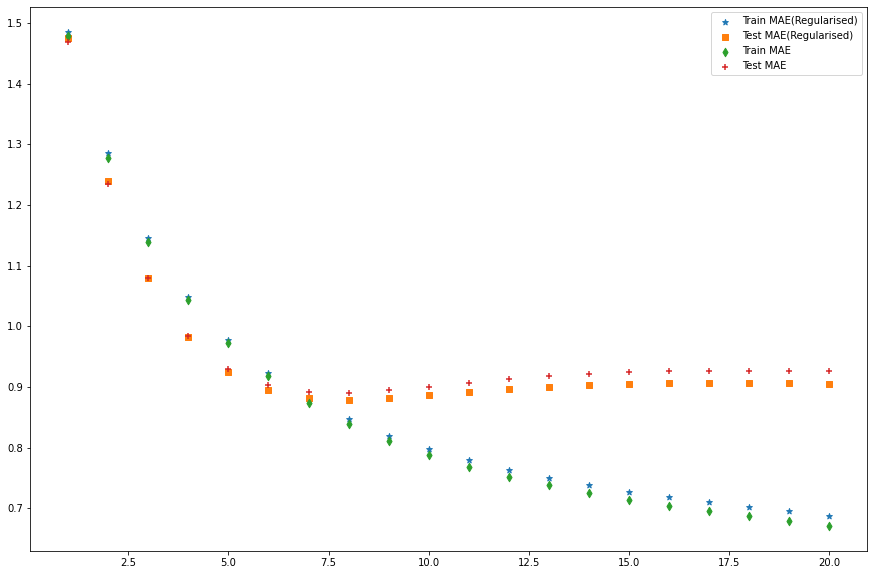

In [206]:
plt.figure(figsize=(15,10))
plt.scatter(range(1,21),regularised_train_mae_each_iteration,marker="*",label="Train MAE(Regularised)")
plt.scatter(range(1,21),regularised_test_mae_each_iteration,marker="s",label="Test MAE(Regularised)")
plt.scatter(range(1,21),train_mae_each_iteration,marker="d",label="Train MAE")
plt.scatter(range(1,21),test_mae_each_iteration,marker="+",label="Test MAE")
plt.legend()
plt.show()



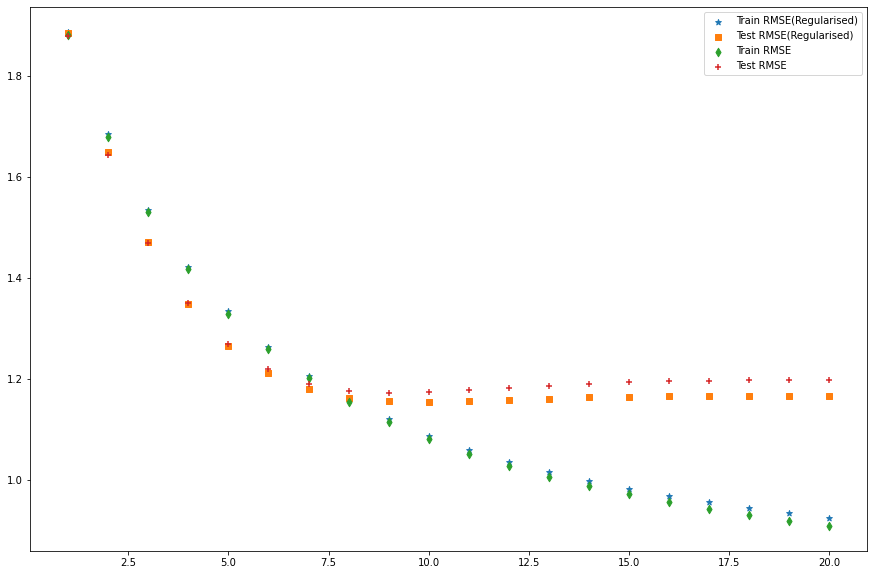

In [207]:
plt.figure(figsize=(15,10))
plt.scatter(range(1,21),regularised_train_rmse_each_iteration,marker="*",label="Train RMSE(Regularised)")
plt.scatter(range(1,21),regularised_test_rmse_each_iteration,marker="s",label="Test RMSE(Regularised)")
plt.scatter(range(1,21),train_rmse_each_iteration,marker="d",label="Train RMSE")
plt.scatter(range(1,21),test_rmse_each_iteration,marker="+",label="Test RMSE")
plt.legend()
plt.show()

In [182]:
import numpy as np

np.savetxt("regularised_train_mae_each_iteration.txt", regularised_train_mae_each_iteration)
np.savetxt("regularised_test_mae_each_iteration.txt", regularised_test_mae_each_iteration)
np.savetxt("regularised_train_rmse_each_iteration.txt", regularised_train_rmse_each_iteration)
np.savetxt("regularised_test_rmse_each_iteration.txt", regularised_test_rmse_each_iteration)

np.savetxt("train_mae_each_iteration.txt",train_mae_each_iteration)
np.savetxt("test_mae_each_iteration.txt",test_mae_each_iteration)
np.savetxt("train_rmse_each_iteration.txt",train_rmse_each_iteration)
np.savetxt("test_rmse_each_iteration.txt",test_rmse_each_iteration)

In [196]:
np.savetxt("regularised_train_mae_each_iteration_k10.txt", regularised_train_mae_each_iteration)
np.savetxt("regularised_test_mae_each_iteration_k10.txt", regularised_test_mae_each_iteration)
np.savetxt("regularised_train_rmse_each_iteration_k10.txt", regularised_train_rmse_each_iteration)
np.savetxt("regularised_test_rmse_each_iteration_k10.txt", regularised_test_rmse_each_iteration)

In [197]:
#regularised_train_mae_each_iteration = np.loadtxt("regularised_train_mae_each_iteration.txt")
#regularised_test_mae_each_iteration = np.loadtxt("regularised_test_mae_each_iteration.txt")
#regularised_train_rmse_each_iteration = np.loadtxt("regularised_train_rmse_each_iteration.txt")
#regularised_test_rmse_each_iteration = np.loadtxt("regularised_test_rmse_each_iteration.txt")